In [2]:
!pip install transformers pillow pandas scikit-learn
!pip install pytesseract


In [3]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import pytesseract
import pandas as pd
import torch
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


c:\Users\EXTRA\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
# Load TrOCR (French handwriting)
print("Loading TrOCR model...")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Loading TrOCR model...



Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
os.environ["TESSDATA_PREFIX"] = r"C:\Program Files\Tesseract-OCR\tessdata"



In [6]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Optional: Resize
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    # Apply adaptive thresholding for better contrast
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 31, 2)
    return Image.fromarray(thresh)


In [7]:
# Function to apply TrOCR
def run_trocr(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return generated_text
    except Exception as e:
        print(f"[TrOCR Error] {image_path}: {e}")
        return ""


In [8]:
# Function to apply Tesseract OCR (Arabic + French)

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Modify with your actual path


def run_tesseract(image_path):
    try:
        image = preprocess_image(image_path)
        text = pytesseract.image_to_string(image, lang='ara+fra')
        return text.strip()
    except Exception as e:
        print(f"[Tesseract Error] {image_path}: {e}")
        return ""


In [9]:
!pip install easyocr


In [10]:
!pip uninstall calamari-ocr -y
!pip install python-bidi==0.6.6 --force-reinstall
!pip install bidi
!pip install --upgrade easyocr


Found existing installation: calamari_ocr 2.3.1
Uninstalling calamari_ocr-2.3.1:
  Successfully uninstalled calamari_ocr-2.3.1
  Obtaining dependency information for python-bidi==0.6.6 from https://files.pythonhosted.org/packages/95/41/d4dbc72b96e2eea3aeb9292707459372c8682ef039cd19fcac7e09d513ef/python_bidi-0.6.6-cp311-cp311-win_amd64.whl.metadata
  Using cached python_bidi-0.6.6-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
Using cached python_bidi-0.6.6-cp311-cp311-win_amd64.whl (160 kB)
  Attempting uninstall: python-bidi
    Found existing installation: python-bidi 0.4.2
    Uninstalling python-bidi-0.4.2:
      Successfully uninstalled python-bidi-0.4.2


ERROR: Could not find a version that satisfies the requirement bidi (from versions: none)
ERROR: No matching distribution found for bidi


In [11]:
import easyocr
reader = easyocr.Reader(["fr","en"])
results = reader.readtext("C:/Users/EXTRA/Desktop/pi_ds/train_dataset/Processed_Prescriptions/0730--8979909--20230705_page_2.jpg")


c:\Users\EXTRA\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [12]:
# Function to process images from the dataset folder
def infer_folder(dataset_path: str):
    results = []

    # Loop through the subfolders within the given folder (train_dataset)
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        
        # Check if the subfolder exists and is a directory
        if os.path.isdir(subfolder_path):
            print(f"[INFO] Processing subfolder: {subfolder}")
            
            # Loop through the image files in the subfolder
            for filename in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, filename)
                
                # Process only image files (e.g., .jpg, .png)
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    print(f"[INFO] Processing image: {file_path}")
                    result = infer_image(file_path)  # Call your OCR processing function
                    if result:
                        results.append(result)

    return results


In [13]:
# Process a single image using both models
def infer_image(image_path):
    trocr_text = run_trocr(image_path)
    tesseract_text = run_tesseract(image_path)
    print(f"[INFO] TrOCR Text Extraction: {trocr_text}")
    print(f"[INFO] Tesseract Text Extraction: {tesseract_text}")
    combined_text = f"TrOCR: {trocr_text}\nTesseract: {tesseract_text}"
    return combined_text


In [14]:
def display_image_with_text(image_path, text):
    image = cv2.imread(image_path)
    if image is None:
        print(f"[ERROR] Could not load image: {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Image: " + os.path.basename(image_path))
    plt.show()

    print("Extracted Text:\n")
    print(text)
    print("=" * 80 + "\n")

[INFO] Processing: 0730--8979909--20230705_page_2.jpg


c:\Users\EXTRA\anaconda3\Lib\site-packages\transformers\generation\utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[INFO] TrOCR Text Extraction: 2 hour hour of Beau Poundhouse.
[INFO] Tesseract Text Extraction: 


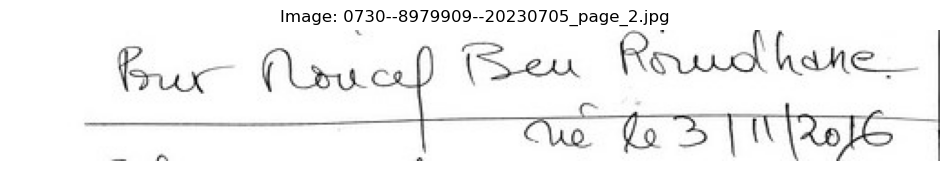

Extracted Text:

TrOCR: 2 hour hour of Beau Poundhouse.
Tesseract: 

[INFO] Processing: 0750--9550274--20230705_page_2.jpg
[INFO] TrOCR Text Extraction: Our Majesty's Party has gone in
[INFO] Tesseract Text Extraction: ستتسابم سسجت


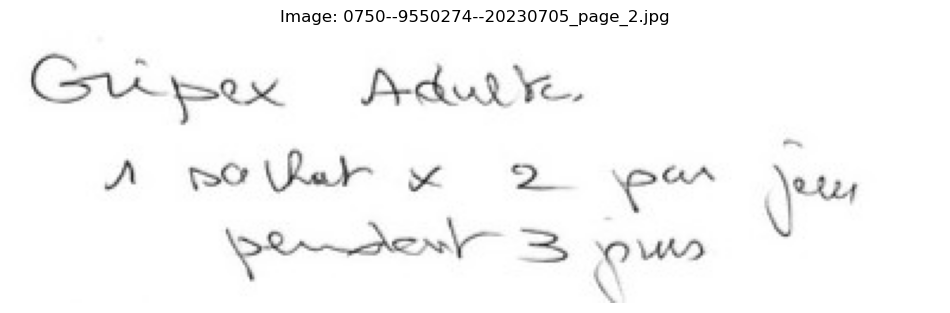

Extracted Text:

TrOCR: Our Majesty's Party has gone in
Tesseract: ستتسابم سسجت

[INFO] Processing: paragh.jpg
[INFO] TrOCR Text Extraction: 0 1
[INFO] Tesseract Text Extraction: ‎ce W‏ # الح


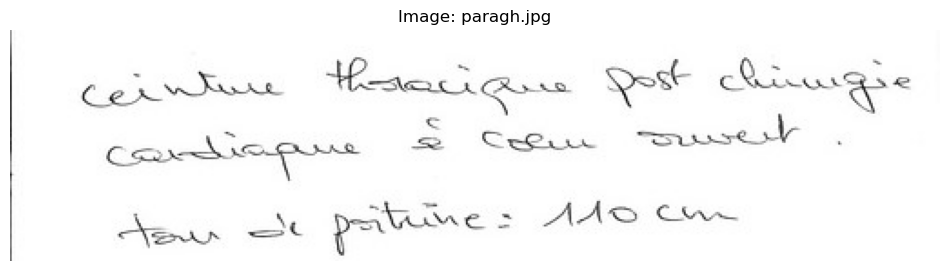

Extracted Text:

TrOCR: 0 1
Tesseract: ‎ce W‏ # الح

[INFO] Processing: patient name.PNG
[INFO] TrOCR Text Extraction: Malek- Djelassi
[INFO] Tesseract Text Extraction: 


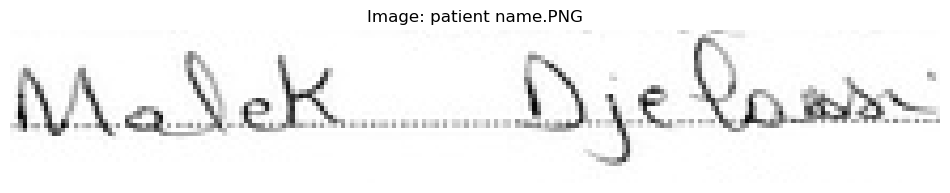

Extracted Text:

TrOCR: Malek- Djelassi
Tesseract: 

[INFO] Processing: patient2.jpg
[INFO] TrOCR Text Extraction: " N. Sinola Boukani
[INFO] Tesseract Text Extraction: 


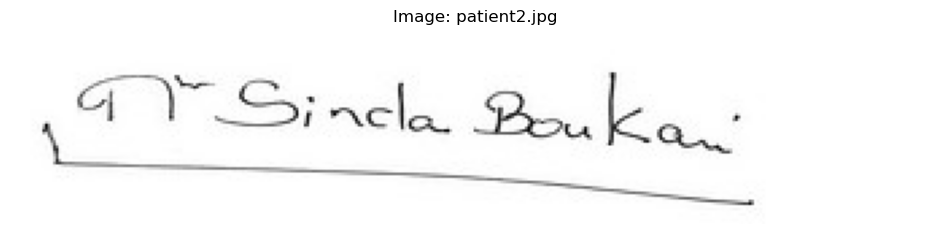

Extracted Text:

TrOCR: " N. Sinola Boukani
Tesseract: 

[INFO] Processing: presciption content.PNG
[INFO] TrOCR Text Extraction: Echo deppler candiapus.
[INFO] Tesseract Text Extraction: 


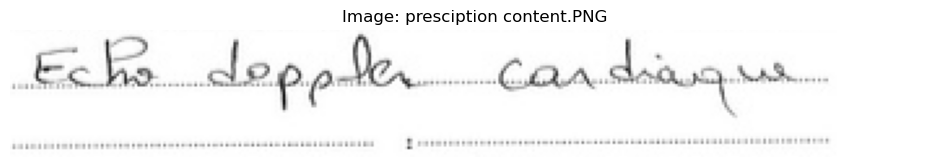

Extracted Text:

TrOCR: Echo deppler candiapus.
Tesseract: 

[INFO] Processing: tmpeya67nom.PNG
[INFO] TrOCR Text Extraction: 2
[INFO] Tesseract Text Extraction: الدكتور رفيق بوسعادة
أخصائي في أمراض القلب و الشرايين
: أستاذ بكلية الطب بترئس سابانا
رئيس قسم بمستشفى الرابطة سابقا


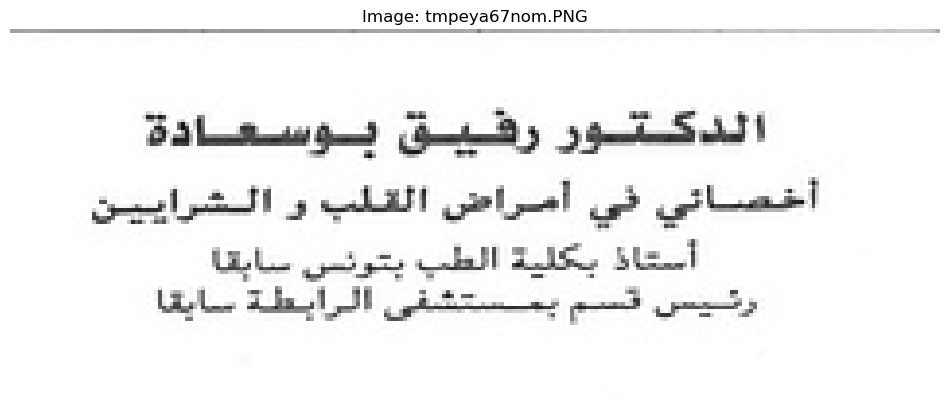

Extracted Text:

TrOCR: 2
Tesseract: الدكتور رفيق بوسعادة
أخصائي في أمراض القلب و الشرايين
: أستاذ بكلية الطب بترئس سابانا
رئيس قسم بمستشفى الرابطة سابقا



In [15]:
if __name__ == "__main__":
    folder_path = r"C:\Users\EXTRA\Desktop\pi_ds\cropped"
    supported_formats = (".jpg", ".jpeg", ".png")

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(supported_formats):
            image_path = os.path.join(folder_path, filename)
            print(f"[INFO] Processing: {filename}")
            extracted_text = infer_image(image_path)
            display_image_with_text(image_path, extracted_text)

In [16]:
# Make sure Tesseract language files are installed (fra+eng)
tess_config = r'--oem 3 --psm 6 -l fra+eng'


In [17]:
def preprocess_handwriting(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Try Otsu + binary inverse
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Dilation to merge connected components better
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 5))
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    
    return dilated


In [18]:
def group_lines(regions, y_thresh=20):
    lines = []
    current_line = []

    for region in sorted(regions, key=lambda b: b[1]):  # sort top to bottom
        if not current_line:
            current_line.append(region)
        elif abs(region[1] - current_line[-1][1]) < y_thresh:
            current_line.append(region)
        else:
            lines.append(current_line)
            current_line = [region]
    if current_line:
        lines.append(current_line)
    return lines


In [19]:

def draw_regions(image, regions):
    output = image.copy()
    for (x, y, w, h) in regions:
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Convert from BGR to RGB for correct matplotlib colors
    output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 12))
    plt.imshow(output_rgb)
    plt.title("Detected Handwritten Regions")
    plt.axis("off")
    plt.show()

In [20]:
def detect_handwritten_regions(thresh_img):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 15 and h > 15:  # Filter small noise
            # Expand box slightly
            padding = 5
            x, y, w, h = x-padding, y-padding, w+2*padding, h+2*padding
            regions.append((x, y, w, h))

    return sorted(regions, key=lambda b: (b[1], b[0]))  # Sort top to bottom, left to right

In [21]:
def extract_text_from_regions(image, regions):
    text_output = ""
    for (x, y, w, h) in regions:
        roi = image[y:y+h, x:x+w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        config = r'--oem 3 --psm 6'
        text = pytesseract.image_to_string(roi, config=config, lang='fra')  # use 'fra' for French
        text_output += text.strip() + "\n"
    return text_output


In [22]:
def infer_image(image_path):
    image = cv2.imread(image_path)
    thresh = preprocess_image(image)
    regions = detect_text_regions(thresh)
    extracted_text = extract_text_from_regions(image, regions)
    return extracted_text


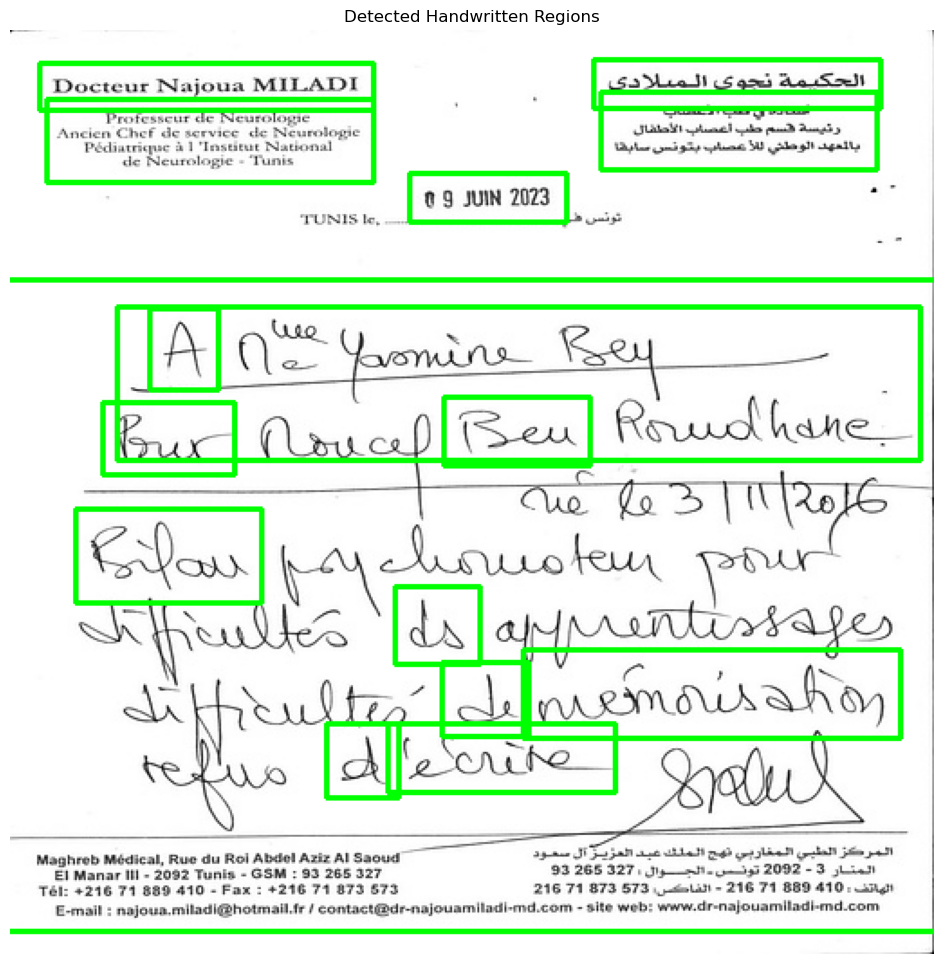

[EXTRACTED TEXT]
Gs Hial s0ù RS
Docteur Najoua MILADI
e p ouce
T
P rs crrr

09 JUN 2023

ﬁ/ÛÏ:{%'},‘È&K_/
E Uœueal) Feu Rouuelhiane _
A
Beu
Buc
Ej
ds
2 é
mrmé sA y
n

LSenète_



In [23]:
# 5. Run the full pipeline
image_path = r"C:/Users/EXTRA/Desktop/pi_ds/train_dataset/Processed_Prescriptions/0730--8979909--20230705_page_2.jpg"
image = cv2.imread(image_path)

preprocessed = preprocess_handwriting(image)
regions = detect_handwritten_regions(preprocessed)
draw_regions(image, regions)

extracted_text = extract_text_from_regions(image, regions)
print(f"[EXTRACTED TEXT]\n{extracted_text}")